# langchain + llamaindex 集成 graphrag

python==3.10

参考：https://github.com/tomasonjo/blogs/blob/master/msft_graphrag/ms_graphrag_retriever.ipynb

In [1]:
!pip install --quiet tqdm neo4j seaborn tiktoken shutup numpy openai

In [2]:
import shutup
shutup.please()

import os
import getpass
from neo4j import GraphDatabase, Result
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import numpy as np
from tqdm import tqdm
from typing import Dict, Any
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Neo4jVector
from langchain_community.graphs import Neo4jGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# pd 展示设置
pd.set_option("display.max_colwidth", None) 
pd.set_option("display.max_columns", None)

In [3]:
NEO4J_URI = "neo4j://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "12345678"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

# 查询函数定义
def db_query(cypher: str, params: Dict[str, Any] = {}) -> pd.DataFrame:
    return driver.execute_query(
        cypher, parameters_=params, result_transformer_=Result.to_df
    )

In [4]:
os.environ["OPENAI_API_KEY"] = "sk-6n3IuwDfeMEZggn2A61a818dC722474292D929C27004Fe82"
os.environ["OPENAI_BASE_URL"] ="http://localhost:13000/v1"

In [5]:
db_query("MATCH (n:__Chunk__) RETURN n.n_tokens as token_count, count(*) AS count")

,token_count,count
0,1200,18
1,907,1
2,1047,1
3,1055,1
4,283,1
5,176,1
6,212,1
7,989,1
8,627,1
9,471,1


In [6]:
db_query(
    "MATCH (n:__Entity__) RETURN n.name AS name, n.description AS description LIMIT 1"
)

,name,description
0,华东理工大学,华东理工大学是一所位于中国东部的高等教育机构，不仅致力于提供本科和研究生教育，还特别关注学生的全面发展和个性化需求。该校制定了一系列管理办法和条例，包括本科生国家奖学金管理办法、社会工作奖评选条例、上海市奖学金管理办法、国家励志奖学金管理办法等，旨在规范奖学金的评审工作，提高学生的管理意识和组织能力，激励家庭经济困难学生勤奋学习。此外，学校还参与实施退役士兵教育资助政策，并制定了毕业生基层就业国家资助管理条例，支持毕业生到中西部地区和艰苦边远地区基层单位就业。\n\n学校设有学生工作部（处），专门负责处理学生的各类事务，确保学生的学习生活顺利进行。为了进一步促进学生的德育发展，华东理工大学还制定了学生德育素质考核的具体实施办法。与此同时，学校非常重视学生的权益保护，规定了学生考核违规处理办法和学生申诉处理规定，并设立了学生申诉处理委员会，以公正、透明的方式处理学生的申诉。此外，该校还制定了学生先进个人和集体评选办法，以表彰在学术、社会实践等方面表现突出的学生和集体。通过这些措施，华东理工大学努力营造一个公平、公正、和谐的校园环境。


In [7]:
db_query("MATCH ()-[n:RELATED]->() RETURN n.description AS description LIMIT 5")

,description
0,《学生违纪处分规定》是由华东理工大学制定并实施的规定，用于管理和规范学生的行为。
1,华东理工大学制定了学生考核违规处理办法，明确了对违规行为的处理措施。
2,华东理工大学制定了学生申诉处理规定，确保学生在受到处分时有申诉的权利。
3,华东理工大学负责管理和实施上海市奖学金，两者之间存在直接的管理和实施关系。
4,华东理工大学制定了具体的管理办法来规范本科生国家奖学金的评审工作。


In [8]:
db_query(
    """
  MATCH (n:__Community__) 
  RETURN n.title AS title, n.summary AS summary, n.full_content AS full_content LIMIT 1
"""
)

,title,summary,full_content
0,大学奖学金申请条件与社区活动,该社区围绕大学奖学金申请条件展开，涵盖了多项评价标准，包括学习成绩、竞赛奖励、社会工作、社会实践和道德风尚等方面。各实体之间关系紧密，尤其在国家奖学金申请条件中，多种成就可以作为申请的补充条件。,"# 大学奖学金申请条件与社区活动\n\n该社区围绕大学奖学金申请条件展开，涵盖了多项评价标准，包括学习成绩、竞赛奖励、社会工作、社会实践和道德风尚等方面。各实体之间关系紧密，尤其在国家奖学金申请条件中，多种成就可以作为申请的补充条件。\n\n## 学习成绩与综合考评的重要性\n\n学习成绩排名与综合考评成绩排名均位于前10%是申请国家奖学金的重要条件之一。这表明学术成绩仍然是评估学生是否适合获得国家奖学金的关键因素。然而，除了学术成绩外，其他方面的表现也可以作为补充条件，增加了奖学金申请的灵活性。[records: Entities (251), Relationships (295)]\n\n## 竞赛奖励在奖学金申请中的作用\n\n获得省（市）、部级及以上竞赛奖励是申请国家奖学金的基本条件之一。这意味着竞赛奖励不仅反映了学生的学术能力和实践技能，还在奖学金申请过程中扮演了重要角色。例如，体育竞赛和艺术展演中的显著成绩也可以作为申请国家奖学金的补充条件，进一步强调了多元化评价的重要性。[records: Entities (199), Relationships (218, 224, 299)]\n\n## 社会工作的多重影响\n\n社会工作B等奖及以上和社会工作方面的显著成绩是申请国家奖学金的基本条件之一。这表明学校非常重视学生在社会服务和志愿服务中的表现，认为这些经历对于学生的全面发展至关重要。此外，社会工作还可以提升学生的领导力和团队合作能力，这对他们的未来职业发展具有积极影响。[records: Entities (250, 256), Relationships (294, 302)]\n\n## 社会实践的意义\n\n在社会实践方面有显著成绩的学生，即使学习成绩排名未达前10%，也可申请国家奖学金。这表明学校鼓励学生积极参与社会实践活动，如志愿服务和社会调研。这些活动不仅有助于学生了解社会现实，还能培养他们的社会责任感和创新能力。[records: Entities (255), Relationships (301)]\n\n## 道德风尚的特别考量\n\n在道德风尚方面有特别优秀表现的学生，即使学习成绩排名未达前10%，也可申请国家奖学金。这一规定旨在激励学生在品德修养方面不断进步，体现了学校对全面发展的重视。道德风尚的评价标准可能包括诚实守信、助人为乐、勇于担当等方面。[records: Relationships (296)]\n\n## 体育竞赛与国家荣誉的关系\n\n在体育竞赛中为国家争得荣誉，如非体育专业学生在省（市）级以上体育比赛中获得个人项目前三名，是申请国家奖学金的加分条件之一。这表明学校高度重视学生在体育领域的成就，并鼓励他们在国际和国内比赛中为国家争光。[records: Entities (212, 262), Relationships (222, 223)]\n\n## 艺术展演的多重价值\n\n艺术展演是指学生在艺术表演和展览中的表现，尤其是在全国性和地方性的艺术展演中所取得的成绩。这一成绩不仅是学生个人能力的体现，也是学校艺术教育水平的重要标志。此外，艺术展演中的显著成绩还是申请上海市奖学金的一个额外条件，这意味着在这些活动中表现出色的学生将有机会获得更多的认可和支持。[records: Entities (213), Relationships (224)]\n\n## 学科竞赛的重要性\n\n在学科竞赛中有显著成绩的学生，即使学习成绩排名未达前10%，也可申请国家奖学金。这表明学科竞赛不仅是学术水平的体现，也是评价学生综合素质的重要途径。通过学科竞赛，学生可以展示他们在特定学科领域的深度理解和创新能力。[records: Relationships (299)]\n\n## 多元化评价体系\n\n综上所述，大学奖学金申请条件涵盖了学习成绩、竞赛奖励、社会工作、社会实践和道德风尚等多个方面，形成了一个多元化的评价体系。这种体系不仅能够全面评估学生的综合素质，还能激励学生在各个方面努力发展，促进其全面发展。[records: NONE]"


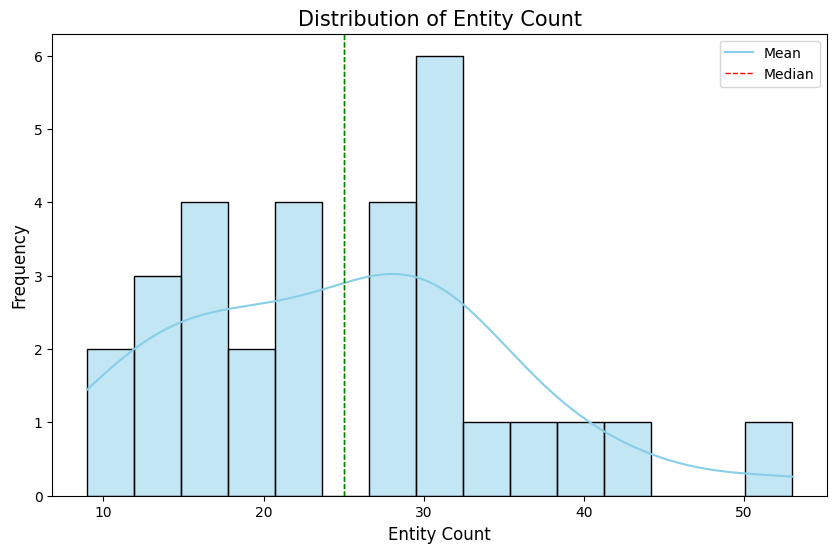

In [9]:
entity_df = db_query(
    """
MATCH (d:__Chunk__)
RETURN count {(d)-[:HAS_ENTITY]->()} AS entity_count
"""
)
# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(entity_df["entity_count"], kde=True, bins=15, color="skyblue")
plt.axvline(
    entity_df["entity_count"].mean(), color="red", linestyle="dashed", linewidth=1
)
plt.axvline(
    entity_df["entity_count"].median(), color="green", linestyle="dashed", linewidth=1
)
plt.xlabel("Entity Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Entity Count", fontsize=15)
plt.legend(
    {
        "Mean": entity_df["entity_count"].mean(),
        "Median": entity_df["entity_count"].median(),
    }
)
plt.show()

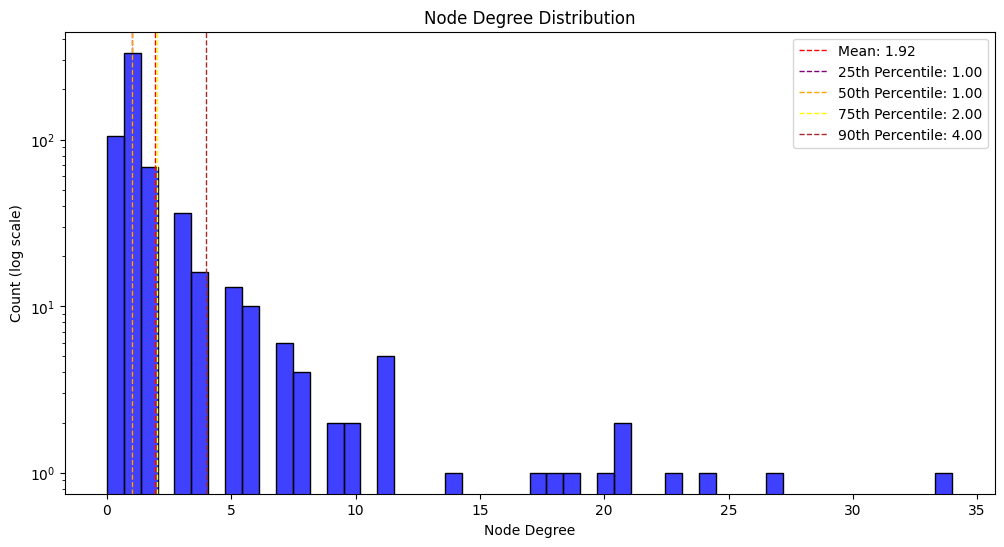

In [10]:
degree_dist_df = db_query(
    """
MATCH (e:__Entity__)
RETURN count {(e)-[:RELATED]-()} AS node_degree
"""
)
# Calculate mean and median
mean_degree = np.mean(degree_dist_df["node_degree"])
percentiles = np.percentile(degree_dist_df["node_degree"], [25, 50, 75, 90])
# Create a histogram with a logarithmic scale
plt.figure(figsize=(12, 6))
sns.histplot(degree_dist_df["node_degree"], bins=50, kde=False, color="blue")
# Use a logarithmic scale for the x-axis
plt.yscale("log")
# Adding labels and title
plt.xlabel("Node Degree")
plt.ylabel("Count (log scale)")
plt.title("Node Degree Distribution")
# Add mean, median, and percentile lines
plt.axvline(
    mean_degree,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Mean: {mean_degree:.2f}",
)
plt.axvline(
    percentiles[0],
    color="purple",
    linestyle="dashed",
    linewidth=1,
    label=f"25th Percentile: {percentiles[0]:.2f}",
)
plt.axvline(
    percentiles[1],
    color="orange",
    linestyle="dashed",
    linewidth=1,
    label=f"50th Percentile: {percentiles[1]:.2f}",
)
plt.axvline(
    percentiles[2],
    color="yellow",
    linestyle="dashed",
    linewidth=1,
    label=f"75th Percentile: {percentiles[2]:.2f}",
)
plt.axvline(
    percentiles[3],
    color="brown",
    linestyle="dashed",
    linewidth=1,
    label=f"90th Percentile: {percentiles[3]:.2f}",
)
# Add legend
plt.legend()
# Show the plot
plt.show()

In [11]:
db_query(
    """
  MATCH (n:__Entity__) 
  RETURN n.name AS name, count{(n)-[:RELATED]-()} AS degree
  ORDER BY degree DESC LIMIT 5"""
)

,name,degree
0,国家奖学金,34
1,上海市奖学金,27
2,社会工作奖,24
3,全日制本科学生,23
4,学生,21


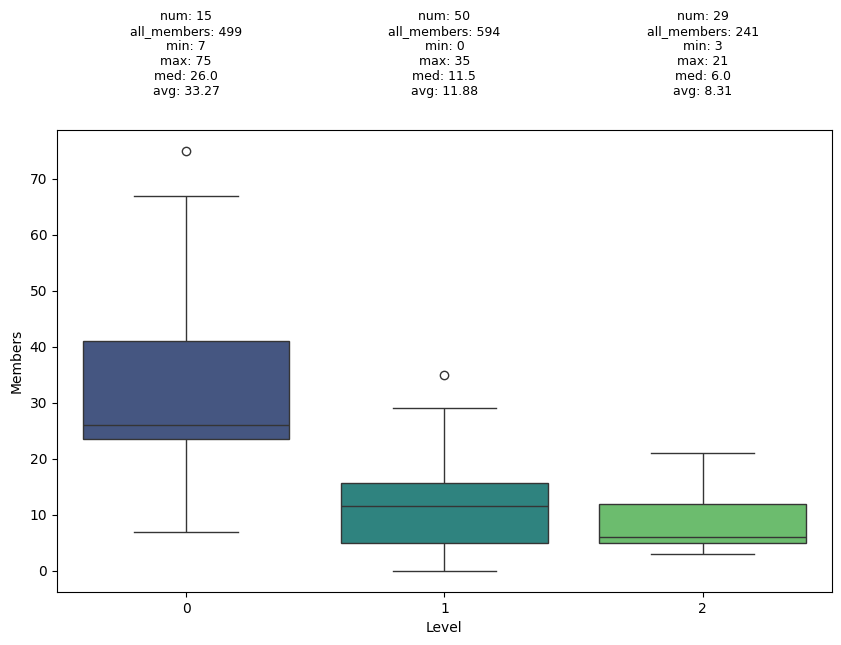

In [12]:
community_data = db_query(
    """
  MATCH (n:__Community__)
  RETURN n.level AS level, count{(n)-[:IN_COMMUNITY]-()} AS members
"""
)

stats = (
    community_data.groupby("level")
    .agg(
        min_members=("members", "min"),
        max_members=("members", "max"),
        median_members=("members", "median"),
        avg_members=("members", "mean"),
        num_communities=("members", "count"),
        total_members=("members", "sum"),
    )
    .reset_index()
)

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="level", y="members", data=community_data, palette="viridis")
plt.xlabel("Level")
plt.ylabel("Members")

# Add statistical annotations
for i in range(stats.shape[0]):
    level = stats["level"][i]
    max_val = stats["max_members"][i]
    text = (
        f"num: {stats['num_communities'][i]}\n"
        f"all_members: {stats['total_members'][i]}\n"
        f"min: {stats['min_members'][i]}\n"
        f"max: {stats['max_members'][i]}\n"
        f"med: {stats['median_members'][i]}\n"
        f"avg: {stats['avg_members'][i]:.2f}"
    )
    plt.text(level, 85, text, horizontalalignment="center", fontsize=9)

plt.show()

以上就是大致预览一下我们构建的graph，现在需要基于graph进行rag

## Local search

![local](./img/local.png)

In [13]:
# 配置向量索引
index_name = "entity"

db_query(
    """
CREATE VECTOR INDEX """
    + index_name
    + """ IF NOT EXISTS FOR (e:__Entity__) ON e.description_embedding
OPTIONS {indexConfig: {
 `vector.dimensions`: 1536,
 `vector.similarity_function`: 'cosine'
}}
"""
)

""


In [14]:
# 计算并存储社区权重（社区中实体出现的不同文本块的数量）
db_query(
    """
MATCH (n:`__Community__`)<-[:IN_COMMUNITY]-()<-[:HAS_ENTITY]-(c)
WITH n, count(distinct c) AS chunkCount
SET n.weight = chunkCount"""
)

""


In [15]:
topChunks = 3
topCommunities = 3
topOutsideRels = 10
topInsideRels = 10
topEntities = 10

In [16]:
lc_retrieval_query = """
WITH collect(node) as nodes
// Entity - Text Unit Mapping
WITH
collect {
    UNWIND nodes as n
    MATCH (n)<-[:HAS_ENTITY]->(c:__Chunk__)
    WITH c, count(distinct n) as freq
    RETURN c.text AS chunkText
    ORDER BY freq DESC
    LIMIT $topChunks
} AS text_mapping,
// Entity - Report Mapping
collect {
    UNWIND nodes as n
    MATCH (n)-[:IN_COMMUNITY]->(c:__Community__)
    WITH c, c.rank as rank, c.weight AS weight
    RETURN c.summary 
    ORDER BY rank, weight DESC
    LIMIT $topCommunities
} AS report_mapping,
// Outside Relationships 
collect {
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE NOT m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT $topOutsideRels
} as outsideRels,
// Inside Relationships 
collect {
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT $topInsideRels
} as insideRels,
// Entities description
collect {
    UNWIND nodes as n
    RETURN n.description AS descriptionText
} as entities
RETURN {Chunks: text_mapping, Reports: report_mapping, 
       Relationships: outsideRels + insideRels, 
       Entities: entities} AS text, 1.0 AS score, {} AS metadata
"""

lc_vector = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(model="text-embedding-3-small"),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name=index_name,
    retrieval_query=lc_retrieval_query,
)

In [17]:
docs = lc_vector.similarity_search(
    "优秀学生的申请条件",
    k=topEntities,
    params={
        "topChunks": topChunks,
        "topCommunities": topCommunities,
        "topOutsideRels": topOutsideRels,
        "topInsideRels": topInsideRels,
    },
)
print(docs[0].page_content)

Entities:
Reports:
Chunks:
Relationships:



In [18]:
!pip install --quiet llama_index llama-index-vector-stores-chroma llama-index-vector-stores-neo4jvector

In [19]:
from llama_index.core.schema import TextNode
from llama_index.core.vector_stores.utils import node_to_metadata_dict
from llama_index.vector_stores.neo4jvector import Neo4jVectorStore
from llama_index.core import VectorStoreIndex

In [20]:
# 需要为节点添加元数据(meta data)，这样矢量索引才能正常工作。如果没有在相关节点中添加默认元数据，矢量索引将返回错误。
content = node_to_metadata_dict(TextNode(), remove_text=True, flat_metadata=False)

db_query(
    """
  MATCH (e:__Entity__)
  SET e += $content""",
    {"content": content},
)


""


In [21]:
embed_dim = 1536

# 首先设置向量搜索的 index_query
index_query = """
CALL db.index.vector.queryNodes("entity", $k, $vector) 
YIELD node, score
"""

# 然后设置检索的查询
retrieval_query = f"""
WITH collect(node) as nodes
// Entity - Text Unit Mapping
WITH
nodes,
collect {{
    UNWIND nodes as n
    MATCH (n)<-[:HAS_ENTITY]->(c:__Chunk__)
    WITH c, count(distinct n) as freq
    RETURN c.text AS chunkText
    ORDER BY freq DESC
    LIMIT {topChunks}
}} AS text_mapping,

// Entity - Report Mapping
collect {{
    UNWIND nodes as n
    MATCH (n)-[:IN_COMMUNITY]->(c:__Community__)
    WITH c, c.rank as rank, c.weight AS weight
    RETURN c.summary 
    ORDER BY rank, weight DESC
    LIMIT {topCommunities}
}} AS report_mapping,

// Outside Relationships 
collect {{
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE NOT m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT {topOutsideRels}
}} as outsideRels,

// Inside Relationships 
collect {{
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT {topInsideRels}
}} as insideRels,

// Entities description
collect {{
    UNWIND nodes as n
    RETURN n.description AS descriptionText
}} as entities

WITH nodes[0] as first_node,
     apoc.text.join(text_mapping, '|') as chunks_text,
     apoc.text.join(report_mapping, '|') as reports_text,
     apoc.text.join(outsideRels + insideRels, '|') as rels_text,
     apoc.text.join(entities, '|') as entities_text

WITH first_node,
     "Chunks:" + chunks_text + 
     "\nReports: " + reports_text +  
     "\nRelationships: " + rels_text + 
     "\nEntities: " + entities_text as full_text

// 构建最终结果，将 node_content 序列化为 JSON 字符串
RETURN 
    full_text AS text,
    1.0 AS score,
    first_node.id AS id,
    {{
        _node_type: "text",
        _node_content: apoc.convert.toJson({{
            id: toString(first_node.id),
            text: full_text,
            metadata: {{}}
        }})
    }} AS metadata
"""

该 `Cypher`查询对一组节点执行多种分析操作，以提取和整理相关文本数据：

1.实体-文本单元映射：对于每个节点，查询会识别链接的文本块（`__Chunk__`），根据与每个文本块相关的不同节点的数量对它们进行聚合，并根据频率对它们进行排序。最重要的文本块以 `text_mapping` 的形式返回。

2.实体-报告映射：对于每个节点，查询会找到相关的社区（`__Community__`），并根据排名和权重返回排名靠前的社区摘要。

3.外部关系：本节提取相关实体（`m`）不属于初始节点集的关系（`RELATED`）描述。这些关系会进行排序，并仅限于最重要的外部关系。

4.内部关系：与外部关系类似，但这次只考虑两个实体都在初始节点集内的关系。

5.实体描述：只需收集初始集合中每个节点的描述。

最后，查询会将收集到的数据合并成一个结构化的结果，其中包括数据块、报告、内部和外部关系以及实体描述，还有一个默认分数和一个空元数据对象。

In [36]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.vector_stores.neo4jvector import Neo4jVectorStore
from llama_index.core import VectorStoreIndex

embed_model = OpenAIEmbedding(model="text-embedding-3-small", api_base="http://localhost:13000/v1")
llm = OpenAI(api_base="http://localhost:13000/v1", model="gpt-4o")

def add_embeddings_to_nodes(session, embed_model):
    result = session.run("""
        MATCH (n:__Entity__)
        WHERE n.description_embedding IS NULL
        RETURN n.id as id, n.description as text
    """)
    records = list(result)
    
    if records:
        print(f"开始为 {len(records)} 个节点添加 embedding")
        for record in records:
            text = record["text"]
            if not text:
                continue
            try:
                embedding = embed_model.get_text_embedding(str(text).strip())  # 确保文本格式正确
                session.run("""
                    MATCH (n:__Entity__ {id: $id})
                    SET n.description_embedding = $embedding
                """, {"id": record["id"], "embedding": embedding})
            except Exception as e:
                print(f"节点 {record['id']} 处理失败")

# 初始化 Neo4j vector store
neo4j_vector = Neo4jVectorStore(
   NEO4J_USERNAME,
   NEO4J_PASSWORD,
   NEO4J_URI,
   embed_dim,
   index_name="entity",
   retrieval_query=retrieval_query,
   index_query=index_query,
)

# 开始embedding
with neo4j_vector._driver.session() as session:
   updated_count = add_embeddings_to_nodes(session, embed_model)

# 创建查询引擎并执行查询
loaded_index = VectorStoreIndex.from_vector_store(neo4j_vector).as_query_engine(
   similarity_top_k=topEntities,
   embed_model=embed_model,
   llm=llm
)

response = loaded_index.query("学生干了什么事会被退学？")
print(response.response)

开始为 30 个节点添加 embedding
学生可能因以下行为被退学：违反宪法、法律、法规，触犯国家法律构成刑事犯罪，或在情节严重、性质恶劣的情况下受到治安管理处罚。此外，代写论文、买卖论文等行为也会导致退学。


# Global Search

In [28]:
llm = ChatOpenAI(model="qwen-plus", streaming=True)

In [29]:
MAP_SYSTEM_PROMPT = """
---Role---

You are a helpful assistant responding to questions about data in the tables provided.


---Goal---

Generate a response consisting of a list of key points that responds to the user's question, summarizing all relevant information in the input data tables.

You should use the data provided in the data tables below as the primary context for generating the response.
If you don't know the answer or if the input data tables do not contain sufficient information to provide an answer, just say so. Do not make anything up.

Each key point in the response should have the following element:
- Description: A comprehensive description of the point.
- Importance Score: An integer score between 0-100 that indicates how important the point is in answering the user's question. An 'I don't know' type of response should have a score of 0.

The response should be JSON formatted as follows:
{{
    "points": [
        {{"description": "Description of point 1 [Data: Reports (report ids)]", "score": score_value}},
        {{"description": "Description of point 2 [Data: Reports (report ids)]", "score": score_value}}
    ]
}}

The response shall preserve the original meaning and use of modal verbs such as "shall", "may" or "will".

Points supported by data should list the relevant reports as references as follows:
"This is an example sentence supported by data references [Data: Reports (report ids)]"

**Do not list more than 5 record ids in a single reference**. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:
"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Reports (2, 7, 64, 46, 34, +more)]. He is also CEO of company X [Data: Reports (1, 3)]"

where 1, 2, 3, 7, 34, 46, and 64 represent the id (not the index) of the relevant data report in the provided tables.

Do not include information where the supporting evidence for it is not provided.


---Data tables---

{context_data}

---Goal---

Generate a response consisting of a list of key points that responds to the user's question, summarizing all relevant information in the input data tables.

You should use the data provided in the data tables below as the primary context for generating the response.
If you don't know the answer or if the input data tables do not contain sufficient information to provide an answer, just say so. Do not make anything up.

Each key point in the response should have the following element:
- Description: A comprehensive description of the point.
- Importance Score: An integer score between 0-100 that indicates how important the point is in answering the user's question. An 'I don't know' type of response should have a score of 0.

The response shall preserve the original meaning and use of modal verbs such as "shall", "may" or "will".

Points supported by data should list the relevant reports as references as follows:
"This is an example sentence supported by data references [Data: Reports (report ids)]"

**Do not list more than 5 record ids in a single reference**. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:
"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Reports (2, 7, 64, 46, 34, +more)]. He is also CEO of company X [Data: Reports (1, 3)]"

where 1, 2, 3, 7, 34, 46, and 64 represent the id (not the index) of the relevant data report in the provided tables.

Do not include information where the supporting evidence for it is not provided.

The response should be JSON formatted as follows:
{{
    "points": [
        {{"description": "Description of point 1 [Data: Reports (report ids)]", "score": score_value}},
        {{"description": "Description of point 2 [Data: Reports (report ids)]", "score": score_value}}
    ]
}}
"""

map_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            MAP_SYSTEM_PROMPT,
        ),
        (
            "human",
            "{question}",
        ),
    ]
)

map_chain = map_prompt | llm | StrOutputParser()

In [30]:
REDUCE_SYSTEM_PROMPT = """
---Role---

You are a helpful assistant responding to questions about a dataset by synthesizing perspectives from multiple analysts.


---Goal---

Generate a response of the target length and format that responds to the user's question, summarize all the reports from multiple analysts who focused on different parts of the dataset.

Note that the analysts' reports provided below are ranked in the **descending order of importance**.

If you don't know the answer or if the provided reports do not contain sufficient information to provide an answer, just say so. Do not make anything up.

The final response should remove all irrelevant information from the analysts' reports and merge the cleaned information into a comprehensive answer that provides explanations of all the key points and implications appropriate for the response length and format.

Add sections and commentary to the response as appropriate for the length and format. Style the response in markdown.

The response shall preserve the original meaning and use of modal verbs such as "shall", "may" or "will".

The response should also preserve all the data references previously included in the analysts' reports, but do not mention the roles of multiple analysts in the analysis process.

**Do not list more than 5 record ids in a single reference**. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:

"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Reports (2, 7, 34, 46, 64, +more)]. He is also CEO of company X [Data: Reports (1, 3)]"

where 1, 2, 3, 7, 34, 46, and 64 represent the id (not the index) of the relevant data record.

Do not include information where the supporting evidence for it is not provided.


---Target response length and format---

{response_type}


---Analyst Reports---

{report_data}


---Goal---

Generate a response of the target length and format that responds to the user's question, summarize all the reports from multiple analysts who focused on different parts of the dataset.

Note that the analysts' reports provided below are ranked in the **descending order of importance**.

If you don't know the answer or if the provided reports do not contain sufficient information to provide an answer, just say so. Do not make anything up.

The final response should remove all irrelevant information from the analysts' reports and merge the cleaned information into a comprehensive answer that provides explanations of all the key points and implications appropriate for the response length and format.

The response shall preserve the original meaning and use of modal verbs such as "shall", "may" or "will".

The response should also preserve all the data references previously included in the analysts' reports, but do not mention the roles of multiple analysts in the analysis process.

**Do not list more than 5 record ids in a single reference**. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:

"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Reports (2, 7, 34, 46, 64, +more)]. He is also CEO of company X [Data: Reports (1, 3)]"

where 1, 2, 3, 7, 34, 46, and 64 represent the id (not the index) of the relevant data record.

Do not include information where the supporting evidence for it is not provided.


---Target response length and format---

{response_type}

Add sections and commentary to the response as appropriate for the length and format. Style the response in markdown.
"""

reduce_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            REDUCE_SYSTEM_PROMPT,
        ),
        (
            "human",
            "{question}",
        ),
    ]
)
reduce_chain = reduce_prompt | llm | StrOutputParser()

In [31]:
graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    refresh_schema=False,
)

response_type: str = "multiple paragraphs"


def global_retriever(query: str, level: int, response_type: str = response_type) -> str:
    community_data = graph.query(
        """
    MATCH (c:__Community__)
    WHERE c.level = $level
    RETURN c.full_content AS output
    """,
        params={"level": level},
    )
    intermediate_results = []
    for community in tqdm(community_data, desc="Processing communities"):
        intermediate_response = map_chain.invoke(
            {"question": query, "context_data": community["output"]}
        )
        intermediate_results.append(intermediate_response)
    final_response = reduce_chain.invoke(
        {
            "report_data": intermediate_results,
            "question": query,
            "response_type": response_type,
        }
    )
    return final_response

In [32]:
print(global_retriever("优秀学生的申请条件", 2))

Processing communities: 100%|███████████████████████████████████████████████████████████| 29/29 [04:14<00:00,  8.77s/it]


## 优秀学生的申请条件综述

### 学术成绩与综合考评
优秀学生的申请条件首先包括学术成绩和综合考评成绩。根据数据，学习成绩排名与综合考评成绩均位于前10%是申请国家奖学金的重要条件之一，这表明学术成绩是评估学生是否适合获得国家奖学金的关键因素 [Data: Reports (251, 295)]。此外，德育考核成绩要求至少达到85分以上，这是申请优秀学生的必要条件之一 [Data: Relationships (339, 344)]。

### 竞赛奖励
获得省（市）、部级及以上竞赛奖励是申请国家奖学金的基本条件之一，这表明竞赛奖励在奖学金申请过程中扮演了重要角色 [Data: Reports (199, 218, 224, 299)]。具体来说，在国际和全国性专业学科竞赛、课外学术科技竞赛、中国“互联网+”大学生创新创业大赛、全国职业院校技能大赛等竞赛中获得一等奖（或金奖）及以上奖励，是学生在学科竞赛方面取得显著成绩的表现。这不仅是申请国家奖学金的加分项，也是评估学生综合素质的重要依据 [Data: Relationships (300)]。

### 社会工作与志愿服务
社会工作B等奖及以上和社会工作方面的显著成绩是申请国家奖学金的基本条件之一，这表明学校非常重视学生在社会服务和志愿服务中的表现 [Data: Reports (250, 256, 294, 302)]。此外，具备较高的社会工作表现，如参与志愿者、社会服务、社会工作、社会实践、无偿献血等活动，可获得0～10分的加分，这也是申请优秀学生的重要条件之一 [Data: Entities (410), Relationships (432)]。

### 特殊表现
在道德风尚方面有特别优秀表现的学生，即使学习成绩排名未达前10%，也可申请国家奖学金，这表明学校重视学生的品德修养 [Data: Reports (296)]。具体表现包括见义勇为、助人为乐、奉献爱心、服务社会、自立自强等行为 [Data: Entities (259)]。此外，优秀的团队合作能力也是申请条件的一部分，鼓励学生积极参与学校、学院和班团集体活动，政治理论学习等 [Data: Entities (409), Relationships (431)]。

### 艺术与体育表现
在艺术展演中取得显著成绩的学生，即使学习成绩排名未